In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools;
import statsmodels.api as sm;
import warnings;
warnings.filterwarnings("ignore");
import statsmodels.formula.api as smf;
import h2o;
from h2o.estimators.glm import H2OGeneralizedLinearEstimator;
from sklearn.ensemble import RandomForestRegressor;

In [40]:
df = pd.read_csv('case-hosp-death.csv')
df

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,02/29/2020,1,14,0
1,03/01/2020,1,4,0
2,03/02/2020,0,23,0
3,03/03/2020,2,22,0
4,03/04/2020,5,22,0
...,...,...,...,...
84,05/23/2020,346,54,37
85,05/24/2020,358,60,24
86,05/25/2020,220,45,13
87,05/26/2020,165,19,6


In [41]:
df['DATE_OF_INTEREST'] = pd.to_datetime(df.DATE_OF_INTEREST)

In [42]:
X = df.drop(['DATE_OF_INTEREST','HOSPITALIZED_COUNT'],axis=1)
y = df['HOSPITALIZED_COUNT']

In [43]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

In [44]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size =0.2)

In [45]:
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

In [46]:
clf.score(x_test,y_test)

0.9420875587831544

In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

19784.976376237206
0.9420875587831543


In [48]:
train_df = df[df['DATE_OF_INTEREST'] < '2020-04-07'] 
len(train_df)

38

In [49]:
train_true_labels = train_df['HOSPITALIZED_COUNT']

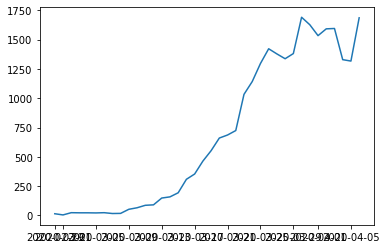

In [50]:
df_date = train_df.DATE_OF_INTEREST.tolist();
df_hspcount = train_df.HOSPITALIZED_COUNT.tolist();
plt.plot(df_date,df_hspcount)
plt.show();

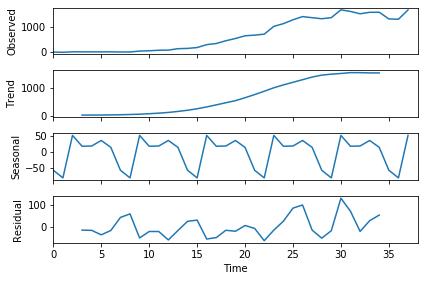

In [51]:
decompose = sm.tsa.seasonal_decompose(df_hspcount,model="additive",freq = 7);
fig = decompose.plot();
plt.show();

In [14]:
p = d = q = range(0,2);
pdq = list(itertools.product(p,d,q));
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))];
print("SARIMA Parameter Combinations");
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_hspcount,order = param,seasonal_order = param_seasonal,
                                      enforce_stationarity = True,enforce_invertibility = False);
            results = mod.fit();
            print("SARIMA {}x{} - AIC: {}".format(param,param_seasonal,results.aic));
        except:
            continue;
#SARIMA Parameter with least AIC Value s (1,1,0), (1,1,0,12)

SARIMA Parameter Combinations
SARIMA (0, 0, 0)x(0, 0, 0, 12) - AIC: 629.7280498632958
SARIMA (0, 0, 0)x(0, 0, 1, 12) - AIC: 1866.0911017678022
SARIMA (0, 0, 0)x(0, 1, 0, 12) - AIC: 421.8942229641286
SARIMA (0, 0, 0)x(1, 0, 0, 12) - AIC: 619.7719106786483
SARIMA (0, 0, 0)x(1, 0, 1, 12) - AIC: 1408.8481906310435
SARIMA (0, 0, 0)x(1, 1, 0, 12) - AIC: 417.7098462811783
SARIMA (0, 0, 1)x(0, 0, 0, 12) - AIC: 584.9631083447653
SARIMA (0, 0, 1)x(0, 0, 1, 12) - AIC: 1426.9968851667015
SARIMA (0, 0, 1)x(0, 1, 0, 12) - AIC: 392.17131636411085
SARIMA (0, 0, 1)x(1, 0, 0, 12) - AIC: 572.8771834509959
SARIMA (0, 0, 1)x(1, 0, 1, 12) - AIC: 1123.0985950322874
SARIMA (0, 0, 1)x(1, 1, 0, 12) - AIC: 389.1140519107141
SARIMA (0, 1, 0)x(0, 0, 0, 12) - AIC: 460.9338499718595
SARIMA (0, 1, 0)x(0, 0, 1, 12) - AIC: nan
SARIMA (0, 1, 0)x(0, 1, 0, 12) - AIC: 328.9154038892483
SARIMA (0, 1, 0)x(1, 0, 0, 12) - AIC: 462.9247710978654
SARIMA (0, 1, 0)x(1, 1, 0, 12) - AIC: 326.5164481186826
SARIMA (0, 1, 1)x(0, 0, 0, 

In [52]:
tsa_mod = sm.tsa.statespace.SARIMAX(df_hspcount,order = (0,1,1),seasonal_order = (1,1,0,12),
                                   enforce_stationarity = True,enforce_invertibility = False);
results = tsa_mod.fit();
tsa_pred = results.get_forecast(10).summary_frame();
pred_val = tsa_pred["mean"];
pred_val;

In [53]:
train_df.drop(["DATE_OF_INTEREST",'HOSPITALIZED_COUNT'], axis=1,inplace=True)

In [23]:
h2o.init()
train = h2o.H2OFrame(train_df);
glm_model = H2OGeneralizedLinearEstimator(family = "gaussian")
glm_model.train(x = ["CASE_COUNT","DEATH_COUNT"],y = "HOSPITALIZED_COUNT",training_frame = train_df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...


H2OStartupError: Cannot find Java. Please install the latest JRE from
http://www.oracle.com/technetwork/java/javase/downloads/index.html

In [54]:
train_df.head()   #X_train

,CASE_COUNT,DEATH_COUNT
0,1,0
1,1,0
2,0,0
3,2,0
4,5,0


In [55]:
train_true_labels[:5] #y_train

0    14
1     4
2    23
3    22
4    22
Name: HOSPITALIZED_COUNT, dtype: int64

In [56]:
actual_label_df = df[(df['DATE_OF_INTEREST'] > '2020-04-06') & (df['DATE_OF_INTEREST'] < '2020-04-17')]

In [57]:
true_labels = actual_label_df['HOSPITALIZED_COUNT']

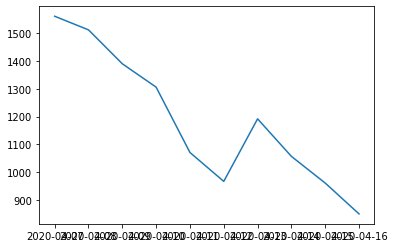

In [58]:
df_date = actual_label_df.DATE_OF_INTEREST.tolist();
df_hspcount = actual_label_df.HOSPITALIZED_COUNT.tolist();
plt.plot(df_date,df_hspcount)
plt.show();

In [59]:
actual_label_df.drop(["DATE_OF_INTEREST",'HOSPITALIZED_COUNT'], axis=1,inplace=True)

In [60]:
actual_label_df.head() #X_test

,CASE_COUNT,DEATH_COUNT
38,6051,590
39,5562,544
40,5035,534
41,4495,517
42,3710,523


In [61]:
true_labels  #y_test

38    1561
39    1512
40    1390
41    1306
42    1071
43     967
44    1192
45    1057
46     961
47     850
Name: HOSPITALIZED_COUNT, dtype: int64

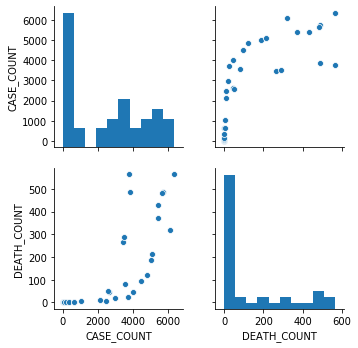

In [62]:
sns.pairplot(train_df)

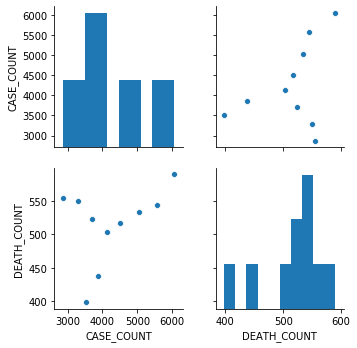

In [63]:
sns.pairplot(actual_label_df)

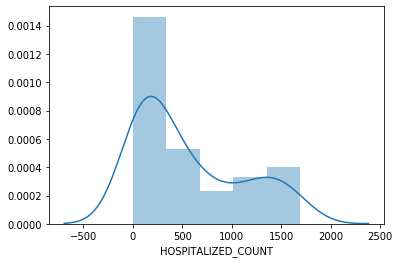

In [64]:
sns.distplot(df.HOSPITALIZED_COUNT)

In [65]:
train_df.head()

,CASE_COUNT,DEATH_COUNT
0,1,0
1,1,0
2,0,0
3,2,0
4,5,0


In [66]:
clf.fit(train_df,train_true_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
pred_new = clf.predict(actual_label_df)

In [68]:
clf.score(actual_label_df,true_labels)

-0.28350763283703007

In [69]:
print(mean_squared_error(true_labels, pred_new))
print(r2_score(true_labels, pred_new))

69860.81988734273
-0.28350763283703007


In [70]:
rfr_mod = RandomForestRegressor(n_estimators = 100,random_state=100);
rfr_mod.fit(train_df,train_true_labels);
rfr_pred = rfr_mod.predict(actual_label_df);
rfr_pred

array([1645.39, 1588.94, 1386.85, 1332.3 , 1328.33, 1265.56, 1331.98,
       1334.05, 1334.05, 1348.45])

In [71]:
error = abs(rfr_pred-true_labels);
mape = 100*(error/true_labels);
accuracy = 100 - np.mean(mape);
accuracy

79.69484981556043